# Lab6 — Integracja Techniki Przetwarzania Obrazów

**Cel:** Zintegrować klasyczne techniki przetwarzania obrazów: filtrację, segmentację, detekcję krawędzi, analizę konturów oraz porównać efekty tych operacji.  
Część praktyczna: realizacja zadań laboratorium (porównania, pomiary metryk i czasów, zapis wyników do PDF).

Wymagane biblioteki:
- numpy, opencv-python, matplotlib, scikit-image, pandas
Instalacja: `pip install numpy opencv-python matplotlib scikit-image pandas`


In [2]:
# Importy i funkcje pomocnicze
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import data, img_as_ubyte, color
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path

plt.rcParams['figure.dpi'] = 120

def show(img, title=None, cmap=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        # If BGR, convert externally; assume input in RGB or grayscale for display
        try:
            plt.imshow(img)
        except:
            plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_multi(imgs, titles, cmap=None, figsize=(15,5)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(imgs, titles)):
        plt.subplot(1, n, i+1)
        if im.ndim == 2:
            plt.imshow(im, cmap=cmap)
        else:
            plt.imshow(im)
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def to_gray_bgr(img):
    # Ensure display uses RGB ordering; if img is BGR (cv2.imread), convert to RGB
    if img.ndim == 3 and img.shape[2] == 3:
        # detect if values look like BGR by checking typical OpenCV load ordering unknown;
        # We're going to assume images used here are RGB from skimage or BGR from cv2 depending on context.
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def ensure_grayscale(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.dtype==np.uint8 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


Używam pliku lokalnego: C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg


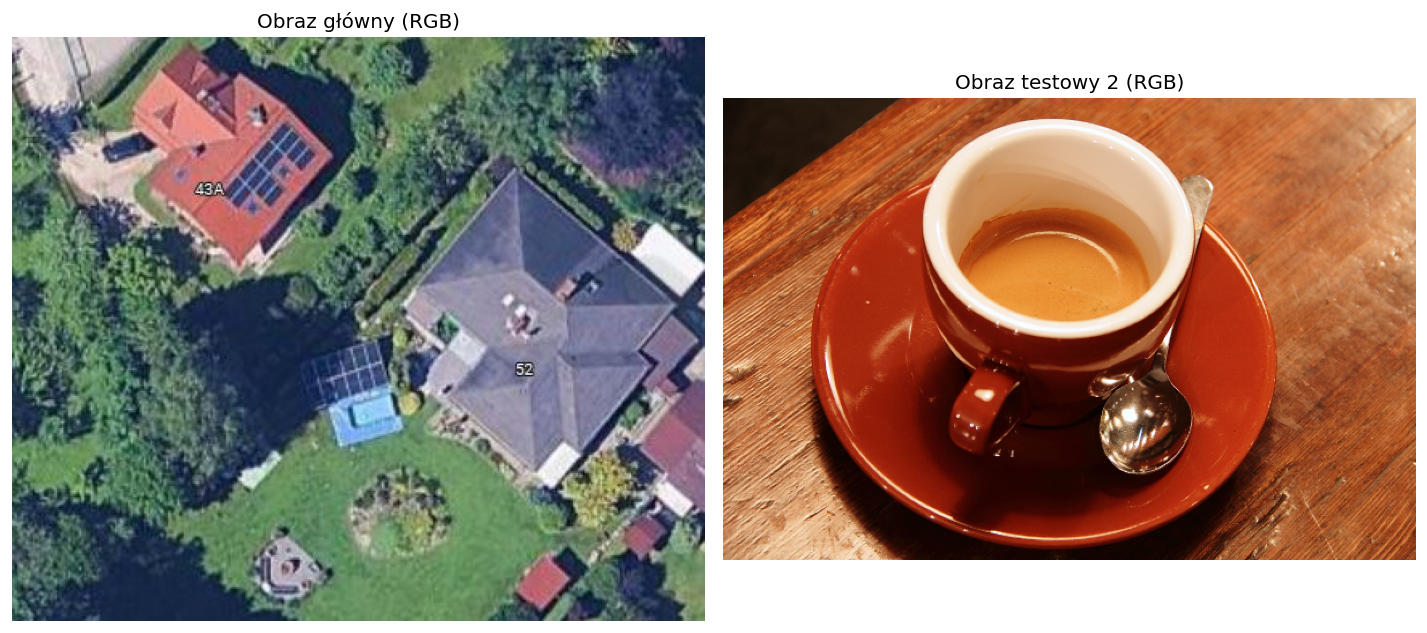

In [3]:
# Wczytanie obrazu testowego. Preferowany plik: '4s.png' (umieścić w katalogu roboczym).
# Jeżeli plik nie istnieje, użyjemy dwóch obrazów z skimage dla porównań: 'astronaut' (kolorowy) i 'coffee'.
# base_path = Path.cwd()

base_path=Path(r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos")

obraz1="3.jpg"
obraz2="5.jpg"

obraz = obraz1

img_path = base_path / obraz

if img_path.exists():
    img_bgr = cv2.imread(str(img_path))
    # convert to RGB for consistent processing/visualization
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    print("Używam pliku lokalnego:", img_path)
else:
    # fallback: use skimage sample color image
    img_rgb = img_as_ubyte(data.astronaut())  # kolorowy wbudowany w biblioteke
    print("Plik 4s.png nie znaleziony — używam obrazu przykładowego 'astronaut'.")

# second test image for stability experiments
img_rgb2 = img_as_ubyte(data.coffee())

# grayscale versions
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img_rgb2, cv2.COLOR_RGB2GRAY)

show_multi([img_rgb, img_rgb2], ["Obraz główny (RGB)", "Obraz testowy 2 (RGB)"], figsize=(12,6))


In [4]:
# Metryki używane w eksperymentach
def iou_mask(m1, m2):
    m1_bin = (m1 > 0).astype(np.uint8)
    m2_bin = (m2 > 0).astype(np.uint8)
    inter = np.logical_and(m1_bin, m2_bin).sum()
    uni = np.logical_or(m1_bin, m2_bin).sum()
    return float(inter) / uni if uni > 0 else 0.0

def dice_mask(m1, m2):
    m1_bin = (m1 > 0).astype(np.uint8)
    m2_bin = (m2 > 0).astype(np.uint8)
    inter = np.logical_and(m1_bin, m2_bin).sum()
    denom = m1_bin.sum() + m2_bin.sum()
    return 2.0 * inter / denom if denom > 0 else 0.0

def compute_ssim(a, b):
    # a, b grayscale uint8
    return ssim(a, b)


# Metryki używane w eksperymentach
# def iou_mask(m1, m2):
#     m1_bin = (m1 > 0).astype(np.uint8)
#     m2_bin = (m2 > 0).astype(np.uint8)
#     inter = np.logical_and(m1_bin, m2_bin).sum()
#     uni = np.logical_or(m1_bin, m2_bin).sum()
#     iou = float(inter) / float(uni) if uni > 0 else 0.0
#     return iou, inter

# def dice_mask(m1, m2):
#     m1_bin = (m1 > 0).astype(np.uint8)
#     m2_bin = (m2 > 0).astype(np.uint8)
#     inter = np.logical_and(m1_bin, m2_bin).sum()
#     denom = m1_bin.sum() + m2_bin.sum()
#     dice = (2.0 * float(inter)) / float(denom) if denom > 0 else 0.0
#     return dice, inter

### Zadanie 1 — Zastosuj filtr medianowy przed segmentacją i porównaj wynik IoU
Procedura:
1. Filtr mediana na obrazie wejściowym (różne rozmiary jądra).
2. Segmentacja Otsu (po filtracji) i progowanie adaptacyjne.
3. Obliczenie IoU i Dice między maską Otsu a adaptacyjną, porównanie z przypadkiem bez mediany.


In [5]:
# Zadanie 1: test z różnymi kernelami mediany
results_med = []
kernels = [1,3,5,7]  # kernel=1 => brak filtra (identity)
for k in kernels:
    if k == 1:
        img_proc = img_gray.copy()
    else:
        img_proc = cv2.medianBlur(img_gray, k)
    # segmentacje
    _, mask_otsu = cv2.threshold(img_proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_adapt = cv2.adaptiveThreshold(img_proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    iou_val = iou_mask(mask_otsu, mask_adapt)
    dice_val = dice_mask(mask_otsu, mask_adapt)
    ssim_val = compute_ssim(mask_otsu, mask_adapt)
    results_med.append({'kernel':k, 'iou':iou_val, 'dice':dice_val, 'ssim_mask':ssim_val})
    print(f"kernel={k}: IoU={iou_val:.4f}, Dice={dice_val:.4f}, SSIM(mask)={ssim_val:.4f}")

df_med = pd.DataFrame(results_med)
display(df_med)


kernel=1: IoU=0.5697, Dice=0.7259, SSIM(mask)=0.3004
kernel=3: IoU=0.5796, Dice=0.7339, SSIM(mask)=0.2707
kernel=5: IoU=0.5860, Dice=0.7389, SSIM(mask)=0.2409
kernel=7: IoU=0.5984, Dice=0.7487, SSIM(mask)=0.2507


,kernel,iou,dice,ssim_mask
0,1,0.569715,0.725883,0.300417
1,3,0.579598,0.733855,0.270654
2,5,0.585968,0.738941,0.240910
3,7,0.598381,0.748734,0.250704


### Zadanie 2 — Zbadaj wpływ wartości progów Canny (dolny, górny) na wynik
Procedura:
1. Przetestować siatkę par progów (low, high).
2. Dla każdego zestawu: wykrycie krawędzi, znalezienie konturów, policzenie liczby konturów i porównanie z referencyjną maską (Otsu).
3. Metryka porównawcza: IoU (po rozszerzeniu krawędzi do maski) oraz liczba wykrytych konturów.


In [6]:
# przygotowanie referencyjnej maski Otsu na obrazie oryginalnym (bez filtracji)
_, ref_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def edges_to_mask(edges, dilate_iter=2):
    # rozszerz krawędzie, by mogły być porównane z maską regionów
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=dilate_iter)
    return mask

canny_params = [(50,150), (75,200), (100,200), (50,200), (30,100)]
res_canny = []
for low, high in canny_params:
    edges = cv2.Canny(img_gray, low, high)
    mask_from_edges = edges_to_mask(edges, dilate_iter=3)
    # porównaj maskę z ref_otsu
    iou_val = iou_mask(mask_from_edges, ref_otsu)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    res_canny.append({'low':low, 'high':high, 'contours':len(contours), 'iou':iou_val})
    print(f"Canny({low},{high}) -> contours: {len(contours)}, IoU vs Otsu: {iou_val:.4f}")

df_canny = pd.DataFrame(res_canny)
display(df_canny)


Canny(50,150) -> contours: 655, IoU vs Otsu: 0.4985
Canny(75,200) -> contours: 489, IoU vs Otsu: 0.4543
Canny(100,200) -> contours: 599, IoU vs Otsu: 0.4467
Canny(50,200) -> contours: 438, IoU vs Otsu: 0.4801
Canny(30,100) -> contours: 1029, IoU vs Otsu: 0.5649


,low,high,contours,iou
0,50,150,655,0.498517
1,75,200,489,0.454266
2,100,200,599,0.446727
3,50,200,438,0.480124
4,30,100,1029,0.564893


### Zadanie 3 — Wykrywanie elips i prostokątów
Algorytm:
- znajdź kontury na masce (np. Otsu),
- dla każdego konturu: aproksymacja poligonalna → jeżeli liczba wierzchołków == 4 → prostokąt (sprawdź kąt i rzut),
- dopasowanie elipsy (cv2.fitEllipse) i ocenianie kształtu wg stosunku osi.


Prostokąty: 0, Elipsy: 4, Pozostałe: 0


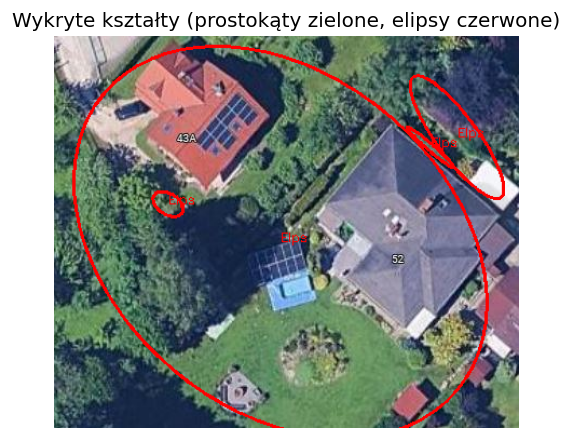

In [7]:
# przygotowanie maski i konturów
_, mask_otsu_full = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(mask_otsu_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_shapes = img_rgb.copy()
ellipse_count = 0
rect_count = 0
other_count = 0
shapes = []

for c in contours:
    area = cv2.contourArea(c)
    if area < 200:  # pomiń drobne szumy
        continue
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    if len(approx) == 4:
        # prostokąt / kwadrat - sprawdź stosunek boków
        x,y,w,h = cv2.boundingRect(approx)
        ar = float(w)/h if h>0 else 0
        rect_count += 1
        label = "Rectangle"
        cv2.drawContours(img_shapes, [approx], -1, (0,255,0), 2)
        cv2.putText(img_shapes, f"Rect", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0),1)
        shapes.append(('rect', area, ar))
    else:
        # spróbuj dopasować elipsę, jeśli kontur ma minimum 5 punktów
        if len(c) >= 5:
            try:
                el = cv2.fitEllipse(c)
                (xc, yc), (major, minor), angle = el
                if minor == 0:
                    continue
                ratio = minor/major if major>0 else 0
                # jeśli ratio bliskie 1 → okrąg/elipsa
                ellipse_count += 1
                cv2.ellipse(img_shapes, el, (255,0,0), 2)
                cv2.putText(img_shapes, f"Elps", (int(xc), int(yc)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0),1)
                shapes.append(('ellipse', area, ratio))
            except Exception as e:
                other_count += 1
        else:
            other_count += 1

print(f"Prostokąty: {rect_count}, Elipsy: {ellipse_count}, Pozostałe: {other_count}")
show(img_shapes, "Wykryte kształty (prostokąty zielone, elipsy czerwone)")


### Zadanie 4 — Porównanie histogramów po filtracji Gaussa i bilateralnej
- Oblicz histogramy intensywności dla obrazu po filtracji Gaussa i po filtracji bilateralnej.
- Porównaj statystycznie (miary: korelacja histogramów, odległość Bhattacharyya lub chi-square).


Korelacja (orig vs gauss): 0.9838087124584478
Korelacja (orig vs bilateral): 0.9465935085133266
Chi-square (orig vs gauss): 6307.251166794401
Chi-square (orig vs bilateral): 14153.525803709685


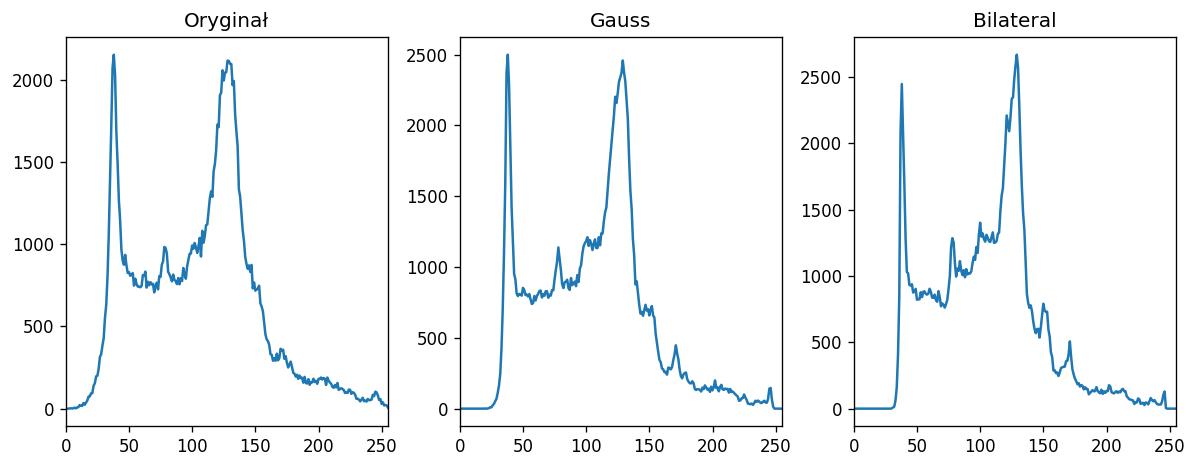

In [8]:
# Filtracja
gauss = cv2.GaussianBlur(img_gray, (5,5), 1.0)
bilat = cv2.bilateralFilter(img_gray, 9, 75, 75)

# histogramy
hist_orig = cv2.calcHist([img_gray],[0],None,[256],[0,256]).flatten()
hist_gauss = cv2.calcHist([gauss],[0],None,[256],[0,256]).flatten()
hist_bilat = cv2.calcHist([bilat],[0],None,[256],[0,256]).flatten()

# porównania histogramów - korelacja i chi-square
corr_gauss = cv2.compareHist(hist_orig.astype('float32'), hist_gauss.astype('float32'), cv2.HISTCMP_CORREL)
corr_bilat = cv2.compareHist(hist_orig.astype('float32'), hist_bilat.astype('float32'), cv2.HISTCMP_CORREL)
chi_gauss = cv2.compareHist(hist_orig.astype('float32'), hist_gauss.astype('float32'), cv2.HISTCMP_CHISQR)
chi_bilat = cv2.compareHist(hist_orig.astype('float32'), hist_bilat.astype('float32'), cv2.HISTCMP_CHISQR)

print("Korelacja (orig vs gauss):", corr_gauss)
print("Korelacja (orig vs bilateral):", corr_bilat)
print("Chi-square (orig vs gauss):", chi_gauss)
print("Chi-square (orig vs bilateral):", chi_bilat)

# wykres
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title('Oryginał'); plt.plot(hist_orig); plt.xlim([0,255])
plt.subplot(1,3,2); plt.title('Gauss'); plt.plot(hist_gauss); plt.xlim([0,255])
plt.subplot(1,3,3); plt.title('Bilateral'); plt.plot(hist_bilat); plt.xlim([0,255])
plt.tight_layout(); plt.show()


### Zadanie 5 — Obliczanie średniej wartości SSIM między maską Otsu a adaptacyjną
Metoda:
- Obliczyć SSIM pomiędzy maskami binarnymi (jako obrazy grayscale).


SSIM (Otsu vs Adaptacyjne): 0.3329260271731951


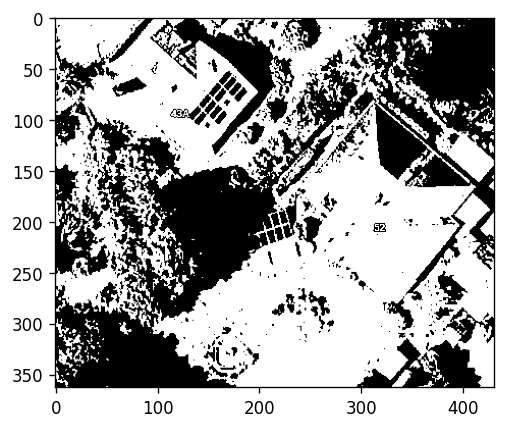

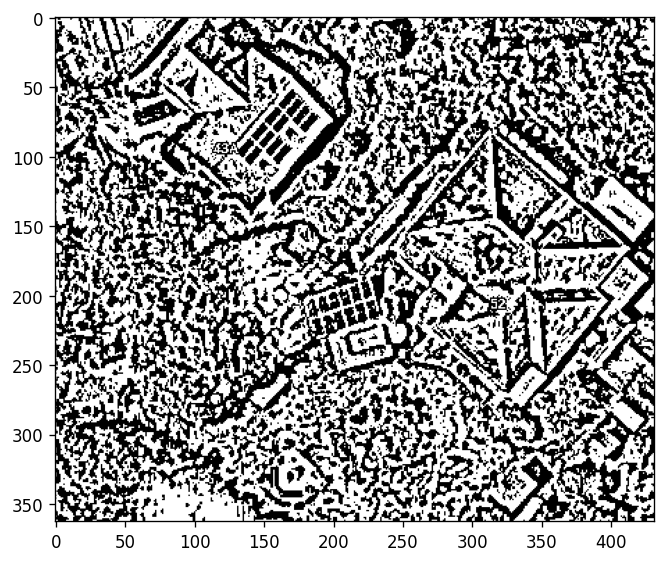

In [9]:
# Obliczenie masek dla porównania (użyjemy obrazu oryginalnego)
_, mask_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask_adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

ssim_val_masks = ssim(mask_otsu, mask_adapt)
print("SSIM (Otsu vs Adaptacyjne):", ssim_val_masks)

plt.figure(figsize=(10,4))
plt.imshow(mask_otsu, cmap='gray')
plt.show()
plt.imshow(mask_adapt, cmap='gray')
plt.tight_layout()
plt.show()

### Zadanie 6 — Rozszerz pipeline o detekcję kolorowych obiektów (przestrzeń HSV)
- Zidentyfikować obiekty określonego koloru (np. czerwony, zielony) poprzez progi w HSV.
- Zastosować operacje morfologiczne do oczyszczenia maski.


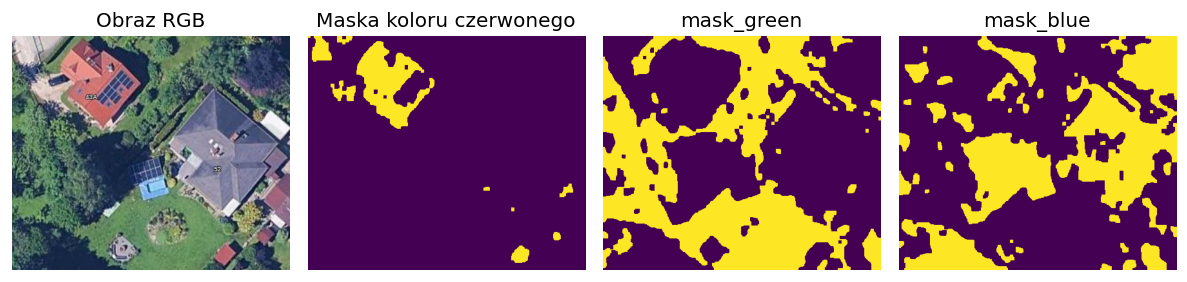

In [10]:
# Detekcja koloru w HSV - przykładowo wykryjemy czerwone obszary
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

kernel = np.ones((5,5), np.uint8)

# zakresy dla czerwieni (uwzględniający przeskok H)
lower1 = np.array([0, 0, 0])
upper1 = np.array([10, 255, 255])
lower2 = np.array([170, 0, 0])
upper2 = np.array([180, 255, 255])

mask1 = cv2.inRange(img_hsv, lower1, upper1)
mask2 = cv2.inRange(img_hsv, lower2, upper2)
mask_red = cv2.bitwise_or(mask1, mask2)

mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

lower1_green = np.array([35, 0, 0])
upper1_green = np.array([85, 255, 255])
mask_green = cv2.inRange(img_hsv, lower1_green, upper1_green)

mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)

lower1_blue = np.array([96, 0, 0])
upper1_blue = np.array([125, 255, 255])
mask_blue = cv2.inRange(img_hsv, lower1_blue, upper1_blue)

mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)
mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel)

show_multi([img_rgb, mask_red,mask_green,mask_blue], ["Obraz RGB", "Maska koloru czerwonego","mask_green","mask_blue"], figsize=(10,5))


### Zadanie 7 — Zapis wyników etapów do pliku PDF
Zestawienie wykresów i obrazów do pliku `Lab6_results.pdf`.


In [51]:
out_pdf = base_path / "Lab6_results.pdf"
with PdfPages(out_pdf) as pdf:
    # strona tytułowa
    plt.figure(figsize=(8.27, 11.69)); plt.axis('off')
    plt.text(0.5, 0.6, 'Lab6 — Integracja Techniki Przetwarzania Obrazów', ha='center', fontsize=16)
    plt.text(0.5, 0.55, f'Plik źródłowy: {img_path.name if img_path.exists() else "skimage.astronaut()"}', ha='center')
    pdf.savefig(); plt.close()
    # oryginał i filtry
    fig = plt.figure(figsize=(8,6))
    plt.subplot(2,3,1); plt.imshow(img_rgb); plt.title('Oryginał'); plt.axis('off')
    plt.subplot(2,3,2); plt.imshow(img_gray, cmap='gray'); plt.title('Gray'); plt.axis('off')
    plt.subplot(2,3,3); plt.imshow(gauss, cmap='gray'); plt.title('Gauss'); plt.axis('off')
    plt.subplot(2,3,4); plt.imshow(bilat, cmap='gray'); plt.title('Bilateral'); plt.axis('off')
    plt.subplot(2,3,5); plt.imshow(mask_otsu, cmap='gray'); plt.title('Maska Otsu'); plt.axis('off')
    plt.subplot(2,3,6); plt.imshow(mask_adapt, cmap='gray'); plt.title('Maska Adapt.'); plt.axis('off')
    pdf.savefig(); plt.close()
    # krawędzie i kontury
    plt.figure(figsize=(8,6))
    edges = cv2.Canny(img_gray, 100, 200)
    plt.subplot(1,2,1); plt.imshow(edges, cmap='gray'); plt.title('Canny 100/200'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_shapes); plt.title('Wykryte kształty'); plt.axis('off')
    pdf.savefig(); plt.close()
    # histogramy
    plt.figure(figsize=(8,6))
    plt.plot(hist_orig, label='orig'); plt.plot(hist_gauss, label='gauss'); plt.plot(hist_bilat, label='bilat')
    plt.legend(); plt.title('Histogramy (porównanie)'); plt.xlim([0,255])
    pdf.savefig(); plt.close()

print("Zapisano plik PDF z wynikami:", out_pdf)


Zapisano plik PDF z wynikami: C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\Lab6_results.pdf


### Zadanie 8 — Użyj innego obrazu testowego i oceń stabilność algorytmów
Procedura: przeprowadź te same kroki (filtracja → segmentacja → krawędzie → kontury) na obrazie `img_rgb2` (coffee) i porównaj metryki.


In [11]:
# pipeline na drugim obrazie

img_gray2 = cv2.cvtColor(img_rgb2, cv2.COLOR_RGB2GRAY)
start = time.perf_counter()
gauss2 = cv2.GaussianBlur(img_gray2, (5,5), 1.0)
_, mask_otsu2 = cv2.threshold(gauss2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edges2 = cv2.Canny(gauss2, 100, 200)
contours2, _ = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
t_elapsed = time.perf_counter() - start
print(f"Obliczenia dla obrazu 2: czas = {t_elapsed:.4f}s, konturów wykryto = {len(contours2)}")
# Porównanie z pierwszym obrazem IoU miedzy maskami Otsu

mask_otsu = cv2.resize(mask_otsu, (600, 400))
mask_otsu2 = cv2.resize(mask_otsu2, (600, 400))

iou_otsu = iou_mask(mask_otsu, mask_otsu2)
print("IoU (Otsu obraz1 vs obraz2):", iou_otsu)


Obliczenia dla obrazu 2: czas = 0.0046s, konturów wykryto = 148
IoU (Otsu obraz1 vs obraz2): 0.33456623753954373


### Zadanie 9 — Zmierz czas wykonania poszczególnych etapów
Zmierzymy czas: filtracja (gauss), segmentacja (otsu), detekcja krawędzi (canny), analiza konturów.


In [12]:
timings = {}
t0 = time.perf_counter()
g = cv2.GaussianBlur(img_gray, (5,5), 1.0)
timings['gauss'] = time.perf_counter() - t0

t0 = time.perf_counter()
_, m_otsu = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
timings['otsu'] = time.perf_counter() - t0

t0 = time.perf_counter()
edges = cv2.Canny(g, 100, 200)
timings['canny'] = time.perf_counter() - t0

t0 = time.perf_counter()
cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
timings['contours'] = time.perf_counter() - t0

print("Czasy (s):", timings)


Czasy (s): {'gauss': 0.0006488000017270679, 'otsu': 0.0013044999996054685, 'canny': 0.001570700000229408, 'contours': 0.002971399999296409}


### Zadanie 10 — Opracuj automatyczny pipeline z parametrami wejściowymi użytkownika
Interfejs: funkcja `run_pipeline(params)` przyjmująca słownik parametrów i zwracająca wyniki (maski, kontury, metryki, czasy).


In [13]:
def run_pipeline(img_rgb_input, params):
    """
    params keys:
      - filter: 'gauss' or 'median' or 'bilateral' or None
      - filter_k: kernel size/int
      - otsu: True/False (apply Otsu)
      - adaptive: True/False (apply adaptive)
      - canny: (low, high) or None
    returns dict with results and timings
    """
    res = {}
    timings = {}
    img_gray_local = cv2.cvtColor(img_rgb_input, cv2.COLOR_RGB2GRAY)
    # filter
    t0 = time.perf_counter()
    if params.get('filter') == 'gauss':
        proc = cv2.GaussianBlur(img_gray_local, (params.get('filter_k',5), params.get('filter_k',5)), 0)
    elif params.get('filter') == 'median':
        k = params.get('filter_k',5)
        proc = cv2.medianBlur(img_gray_local, k)
    elif params.get('filter') == 'bilateral':
        proc = cv2.bilateralFilter(img_gray_local, 9, 75, 75)
    else:
        proc = img_gray_local.copy()
    timings['filter'] = time.perf_counter() - t0
    res['proc'] = proc

    # Otsu
    t0 = time.perf_counter()
    _, mask_otsu_local = cv2.threshold(proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) if params.get('otsu', True) else (None, None)
    timings['otsu'] = time.perf_counter() - t0
    res['mask_otsu'] = mask_otsu_local

    # adaptive
    t0 = time.perf_counter()
    if params.get('adaptive', True):
        mask_adapt_local = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    else:
        mask_adapt_local = None
    timings['adaptive'] = time.perf_counter() - t0
    res['mask_adapt'] = mask_adapt_local

    # canny
    t0 = time.perf_counter()
    if params.get('canny') is not None:
        low, high = params['canny']
        edges_local = cv2.Canny(proc, low, high)
    else:
        edges_local = None
    timings['canny'] = time.perf_counter() - t0
    res['edges'] = edges_local

    # contours on selected mask (prefer Otsu if present)
    t0 = time.perf_counter()
    mask_for_contour = mask_otsu_local if mask_otsu_local is not None else (mask_adapt_local if mask_adapt_local is not None else proc>0)
    contours_local, _ = cv2.findContours(mask_for_contour.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    timings['contours'] = time.perf_counter() - t0
    res['contours'] = contours_local
    res['timings'] = timings

    # basic metrics: IoU(Otsu, Adaptive) if both present
    if mask_otsu_local is not None and mask_adapt_local is not None:
        res['iou'] = iou_mask(mask_otsu_local, mask_adapt_local)
        res['dice'] = dice_mask(mask_otsu_local, mask_adapt_local)
        res['ssim_mask'] = ssim(mask_otsu_local, mask_adapt_local)
    else:
        res['iou'] = None; res['dice'] = None; res['ssim_mask'] = None

    return res

# Przykładowe wywołanie
params_example = {'filter':'median','filter_k':5,'otsu':True,'adaptive':True,'canny':(100,200)}
out_example = run_pipeline(img_rgb, params_example)
print("Przykładowe metryki:", {k:out_example.get(k) for k in ['iou','dice','ssim_mask']})
print("Czasy:", out_example['timings'])


Przykładowe metryki: {'iou': np.float64(0.5859683550044111), 'dice': np.float64(0.7389407905339718), 'ssim_mask': np.float64(0.24091025427622534)}
Czasy: {'filter': 0.0009666000005381647, 'otsu': 0.00019350000002305023, 'adaptive': 0.0009618999993108446, 'canny': 0.0018946999989566393, 'contours': 0.0009695999997347826}


## 🧠 Pytania kontrolne — Lab6: Integracja technik przetwarzania obrazów

1. **Jakie są główne etapy klasycznego pipeline’u przetwarzania obrazu** i jaka jest ich kolejność w tym laboratorium?

2. **Na czym polega różnica między wyrównywaniem histogramu (Histogram Equalization) a jego rozciąganiem (Histogram Stretching)?**

3. **Jakie są zalety stosowania filtru bilateralnego w porównaniu z filtrem Gaussa** w kontekście redukcji szumu i zachowania krawędzi?

4. **W jaki sposób metoda Otsu wybiera wartość progu progowania globalnego?**
   Co odróżnia ją od progowania adaptacyjnego?

5. **Jakie informacje o obrazie można uzyskać na podstawie porównania masek segmentacyjnych** przy użyciu metryk IoU i Dice?

6. **Jakie znaczenie mają progi dolny i górny w detektorze krawędzi Canny?**
   Jak wpływają one na liczbę i jakość wykrywanych krawędzi?

7. **Jak można matematycznie określić kołowość obiektu na podstawie jego konturu?**
   Podaj wzór i wyjaśnij jego interpretację fizyczną.

8. **Jakie wnioski można wyciągnąć z porównania histogramów po filtracji Gaussa i bilateralnej?**
   Jak korelacja histogramów informuje o podobieństwie obrazów?

9. **Jakie są praktyczne zastosowania segmentacji kolorowej w przestrzeni HSV?**
   W jakich sytuacjach ta metoda jest bardziej skuteczna niż segmentacja w przestrzeni RGB?

10. **Jakie zalety ma stworzenie zintegrowanego pipeline’u przetwarzania obrazów z możliwością parametryzacji wejściowej użytkownika?**
    Jakie aspekty można w ten sposób zoptymalizować (np. czas, jakość, adaptacyjność)?
